# Checking Sign Conventions
The sign convention for current varies between sources of battery data.
Some define "charging" as positive whereas for others charging is negative current.
The ``SignConventionChecker`` class checks whether our sign choice in the battery-data-toolkit, "charging current is postive," is followed.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from battdat.consistency.current import SignConventionChecker
from battdat.data import BatteryDataset
from datetime import datetime, timedelta

## Load Example Data
We have two simple cells that vary only by the where the "cycle" starts.

In [2]:
from battdat.io.batterydata import BDReader
dataset = BDReader().read_dataset(['../../../tests/files/batterydata/p492-13-raw.csv'])

## Voltage Should Increase During Charge
The core concept behind our sign convention is that the voltage for a battery should increase while it is charging: an principle that is true for many types of batteries.

The algorithm for checking a dataset is consistent with this principle is conceptually simple:
1. Find a point where the current is the most constant
2. Measure the slope between voltage and time.
3. Make sure the slope and the current have the same sign (if voltage 📈, current ➕)

There are, however, a few nuances to the actual implementation.

### Step 1: Finding a Region of Stable Current
Time spans with stable current are where the standard deviation of current is small.
The checker finds the most-stable region using Panda's windowing function.

Start by converting the "test_time" column in data to a Python time object so that Pandas can compute windows corresponding to a specific time span.

In [3]:
raw_data = dataset.raw_data.query('test_time < 8000').copy()  # Get a subset of the timesteries
raw_data['timestamp'] = raw_data['test_time'].apply(datetime.fromtimestamp)

A window of 6 minutes is short enough to find nearly-constant spans of current
and long enough that transient fluctuations in voltage should have a minimal expect.
> NOTE: The window size is an adjustable parameter in `SignConventionChecker`

In [4]:
current_std = raw_data.rolling(timedelta(seconds=360), on='timestamp')['current'].std()

Text(0.5, 0, 'Time (s)')

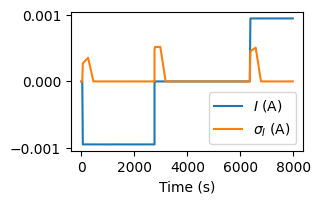

In [5]:
fig, ax = plt.subplots(figsize=(3., 1.8))

ax.plot(raw_data['test_time'], raw_data['current'], label='$I$ (A)')
ax.plot(raw_data['test_time'], current_std, label='$\\sigma_I$ (A)')

ax.legend()
ax.set_xlabel('Time (s)')

There are plenty of regions of stable current in this data and some where the current is nonzero.

In [6]:
window = raw_data.query('1000 < test_time < 2000')

In [7]:
window

,cycle_number,step_index,test_time,current,voltage,temperature,time,timestamp
16,0,5,1052.958,-0.00095,3.183413,29.8454,1.578067e+09,1969-12-31 19:17:32.958
17,0,5,1252.962,-0.00095,3.166171,29.8776,1.578067e+09,1969-12-31 19:20:52.962
18,0,5,1452.960,-0.00095,3.148165,29.8937,1.578067e+09,1969-12-31 19:24:12.960
19,0,5,1652.958,-0.00095,3.129091,29.8454,1.578067e+09,1969-12-31 19:27:32.958
20,0,5,1852.962,-0.00095,3.109255,29.8293,1.578068e+09,1969-12-31 19:30:52.962


## Step 2: Compute the slope between voltage and time
The [slope between two variables is proportional to the covariance](https://en.wikipedia.org/wiki/Simple_linear_regression#Relationship_with_the_sample_covariance_matrix), which can also be computed for a rolling window

In [8]:
cov = raw_data.rolling(timedelta(seconds=360), on='timestamp')['voltage'].cov(raw_data['test_time'])

Text(0.5, 24.0, 'Time (s)')

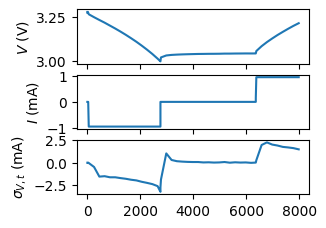

In [9]:
fig, axs = plt.subplots(3, 1, figsize=(3., 2.4), sharex=True)

axs[0].plot(raw_data['test_time'], raw_data['voltage'])
axs[0].set_ylabel('$V$ (V)')

axs[1].plot(raw_data['test_time'], raw_data['current'] * 1000)
axs[1].set_ylabel('$I$ (mA)')

axs[2].plot(raw_data['test_time'], cov)
axs[2].set_ylabel('$\\sigma_{V,t}$ (mA)')

ax.legend()
ax.set_xlabel('Time (s)')

Note how the covariance between voltage and time ($\sigma_{V,t}$) has the same sign as the current for the regions where the data are the same.

## Step 3: Compare signs
The ``SignConventionChecker`` does these two previous steps and compares the outcome

In [10]:
chckr = SignConventionChecker()
chckr.check(dataset)

[]

No errors for this dataset. ✅

If we change the sign, the checker will notice and report why the data are wrong

In [11]:
dataset.raw_data['current'] *= -1
chckr.check(dataset)

['Potential sign error in current. Average current between test_time=299170.4s and test_time=299530.4 is 9.5e-03 A and the covariance between the voltage and current is -1.5e+00 V-s. The current and this covariance should have the same sign.']